In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt

### Useful functions

#### Plotting functions

In [2]:
def gaussian_ellipse(mean, cov):
    if mean.shape == (1,2):
        mean = np.array(mean)[0]
        
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    rtheta = np.arctan2(u[1], u[0])
    v = 3. * np.sqrt(2.) * np.sqrt(v)
    width = v[0]; height = v[1]
    
    R = np.array([
        [np.cos(rtheta), -np.sin(rtheta)],
        [np.sin(rtheta),  np.cos(rtheta)],
        ])    
    theta = np.deg2rad(np.arange(0.0, 360.0, 1.0))
    x = 0.5 * width * np.cos(theta)
    y = 0.5 * height * np.sin(theta)    
    x, y = np.dot(R,np.array([x, y]))
    x += mean[0]
    y += mean[1]
    
    return [x,y]

#### Network generation functions

In [3]:
def symmetrises(A, diag=False):
    if diag:
        return np.tril(A,0) + np.transpose(np.tril(A,-1))
    else:
        return np.tril(A,-1) + np.transpose(np.tril(A,-1))

In [4]:
def generate_SBM(B, pi, n):
    K = B.shape[0]
    Z = np.random.choice(K, p=pi, size=n)
    A = symmetrises(stats.bernoulli.rvs(B[Z,:][:,Z]))
        
    return (A, Z)

#### Embedding functions

In [5]:
def embed(A, B, C, Z, pi):
    K = len(pi)
    P = B[Z,:][:,Z]
            
    # Spectral embeddings
    UA, SA, VAt = np.linalg.svd(A); VA = VAt.T
    UB, SB, VBt = np.linalg.svd(B); VB = VBt.T
    UP, SP, VPt = np.linalg.svd(P); VP = VPt.T
    
    # Find effective embedding dimension by ignoring (nearly) zero eigenvalues
    d = np.sum(SB > 1e-10)

    XA = UA[:,0:d].dot(np.diag(np.sqrt(SA[0:d])))
    XB = UB[:,0:d].dot(np.diag(np.sqrt(SB[0:d])))
    XP = UP[:,0:d].dot(np.diag(np.sqrt(SP[0:d])))

    X = XB[Z,:]
    
    # Find spectral embedding map to latent positions
    UW, _, VWt = np.linalg.svd(UP[:,0:d].T.dot(UA[:,0:d]) + VP[:,0:d].T.dot(VA[:,0:d]))
    W = UW.dot(VWt)
    L = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(XP)).dot(W)
    
    XC = XB.dot(L)
    
    # Covariance matrices 
    Sigmas = np.zeros((K,d,d))
    for i in range(K):
        for j in range(K):
            Sigmas[i] += pi[j]*C[i,j]*np.outer(XB[j],XB[j])
        
    Delta = np.zeros((d,d))
    for i in range(K):
        Delta += pi[i]*np.outer(XB[i],XB[i])

    XBinv = np.linalg.pinv(XB) # XB may not be square
    Ipq = XBinv.dot(B.dot(XBinv.T))
    D = Ipq.dot(np.linalg.inv(Delta))
    
    SigmaXCs = np.zeros((K,d,d))
    for i in range(K):
        SigmaXCs[i] = L.T.dot(D.dot(Sigmas[i].dot(D.T))).dot(L)
   
    return (XA, XC, SigmaXCs, Ipq, L)

I'm not entirely sure I have the correct versions of the one-step algorithm or for compute the $\mathbf{G}$ matrices; there may be an $\mathbf{I}_{pq}$ term missing in certain spots. However, it at least looks convincing, and I'm fairly certain it gives the correct results when $\mathbf{I}_{pq}$ is the identity matrix. This can be investigated further if we look at versions of this algorithm for weighted generalised random dot product graphs.

In [6]:
def onestep(XA, A, Ipq):
    n, d = XA.shape
    X1 = np.zeros((n,d))
    
    for i in range(n):
        M1 = np.zeros((d,d))
        M2 = np.zeros(d)
        for j in range(n):
            pij = XA[i].T.dot(Ipq.dot(XA[j]))
            M1 += np.outer(XA[j], XA[j]) / (pij*(1-pij))
            M2 += (A[i,j]-pij)*XA[j] / (pij*(1-pij))
        X1[i] = XA[i] + Ipq.dot(np.linalg.inv(M1/n).dot(M2/n))
    
    return X1

In [7]:
def onestep_Gs(B, pi):
    K = len(pi)
    UB, SB, VBt = np.linalg.svd(B)
    
    # Find effective embedding dimension by ignoring (nearly) zero eigenvalues
    d = np.sum(SB > 1e-10)
    XB = UB[:,0:d].dot(np.diag(np.sqrt(SB[0:d])))
    
    Gs = np.zeros((K,d,d))
    for i in range(K):
        for j in range(K):
            Gs[i] += pi[j]*np.outer(XB[j],XB[j]) / (B[i,j]*(1-B[i,j]))
            
    return Gs

### $K$-community SBM

In [8]:
np.random.seed(42)

In [9]:
K = 2     # Number of communities
n = 1000  # Number of nodes
rho = 0.2 # Sparsity factor

# Community assignment
pi = np.repeat(1/K, K)

B = symmetrises(rho*stats.uniform.rvs(0,1,size=(K,K)), True)
C = B*(1-B)
print(np.round(B,3))

[[0.075 0.146]
 [0.146 0.12 ]]


In [10]:
A, Z = generate_SBM(B, pi, n)

colours = np.array(list(mpl.colors.TABLEAU_COLORS.keys())[0:K])
Zcol = colours[Z]

In [11]:
XA, XC, SigmaXCs, Ipq, L = embed(A, B, C, Z, pi)

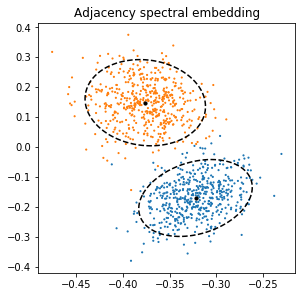

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4.6,4.6))

ax.scatter(XA[:,0], XA[:,1], marker='.', s=5, c=Zcol)
ax.scatter(XC[:,0], XC[:,1], marker='o', s=10, c='black')
ax.set_title('Adjacency spectral embedding')

# Save limits for later use
xlim = ax.get_xlim()
ylim = ax.get_ylim()

for i in range(K):
    ellipse = gaussian_ellipse(XC[i], SigmaXCs[i][0:2,0:2]/n)
    ax.plot(ellipse[0],ellipse[1],'--', color='black')

In [13]:
X1 = onestep(XA, A, Ipq)
Gs = onestep_Gs(B, pi)

# Rotate theoretical covariance term by the ASE transformation
SigmaGs = np.zeros(Gs.shape)
for i in range(K):
    SigmaGs[i] = L.T.dot(Ipq).dot(np.linalg.inv(Gs[i])).dot(Ipq).dot(L)

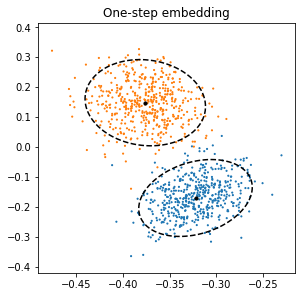

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4.6,4.6))

ax.scatter(X1[:,0], X1[:,1], marker='.', s=5, c=Zcol)
ax.scatter(XC[:,0], XC[:,1], marker='o', s=10, c='black')
ax.set_title('One-step embedding')

# Use previous limits as we often get extreme one-step embedding values
ax.set_xlim(xlim)
ax.set_ylim(ylim)

for i in range(K):
    ellipse = gaussian_ellipse(XC[i], SigmaGs[i][0:2,0:2]/n)
    ax.plot(ellipse[0],ellipse[1],'--', color='black')

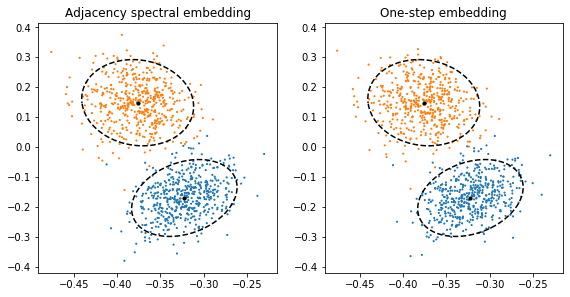

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(9.4,4.6))

ax[0].scatter(XA[:,0], XA[:,1], marker='.', s=5, c=Zcol)
ax[0].scatter(XC[:,0], XC[:,1], marker='o', s=10, c='black')
ax[0].set_title('Adjacency spectral embedding')

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)

for i in range(K):
    ellipse = gaussian_ellipse(XC[i], SigmaXCs[i][0:2,0:2]/n)
    ax[0].plot(ellipse[0],ellipse[1],'--', color='black')
    
ax[1].scatter(X1[:,0], X1[:,1], marker='.', s=5, c=Zcol)
ax[1].scatter(XC[:,0], XC[:,1], marker='o', s=10, c='black')
ax[1].set_title('One-step embedding')

ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)

for i in range(K):
    ellipse = gaussian_ellipse(XC[i], SigmaGs[i][0:2,0:2]/n)
    ax[1].plot(ellipse[0],ellipse[1],'--', color='black')

It appears that the covariance matrix terms are identical in the two approaches!